In [6]:
import os
from pdf2image import convert_from_path

# Path to your PDF file
pdf_path = "dataset/Twinkle_Twinkle_Little_Star.pdf"  # Use forward slashes or raw string

# Manually specify Poppler path (Windows)
poppler_path = r"C:\tools\poppler\Library\bin"  # Ensure this is correct

# Convert PDF to images
images = convert_from_path(pdf_path, dpi=300, poppler_path=poppler_path)

# Output folder
output_folder = os.path.splitext(os.path.basename(pdf_path))[0]
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Save images as PNG
for i, img in enumerate(images):
    output_path = os.path.join(output_folder, f"page_{i+1}.png")
    img.save(output_path, "PNG")

print("PDF successfully converted to PNG!")

PDF successfully converted to PNG!


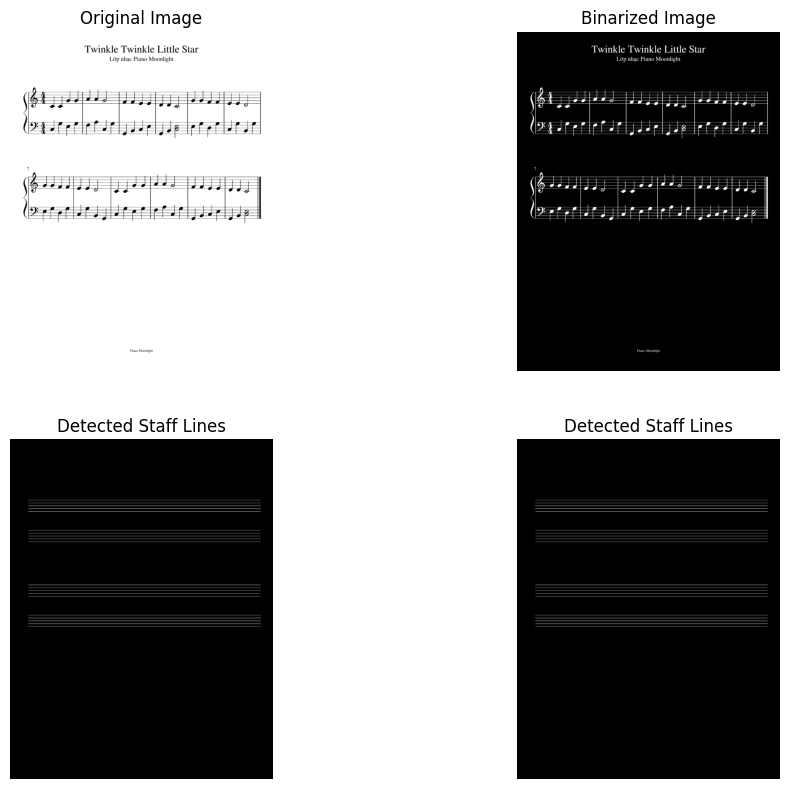

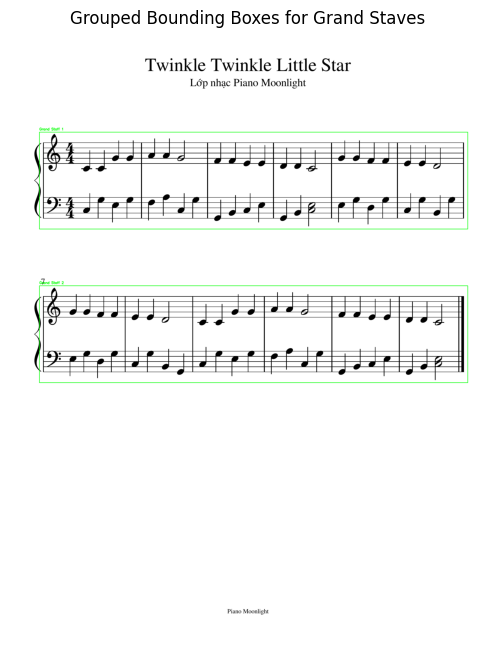

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "Twinkle_Twinkle_Little_Star/page_1.png"  # Update with the correct path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display Original Image
plt.figure(figsize=(12, 15))
plt.subplot(3, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Check if the image was loaded correctly
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Step 1: Preprocessing - Binarize the image
_, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

# Display Binary Image
plt.subplot(3, 2, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Step 2: Detect horizontal lines (staff lines)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (image.shape[1] // 30, 1))
detected_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

# Display Detected Line
plt.subplot(3, 2, 3)
plt.imshow(detected_lines, cmap='gray')
plt.title("Detected Staff Lines")
plt.axis("off")

# Step 3: Find contours of staff lines
contours, _ = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])  # Sort by vertical position (y-coordinate)

# Calculate line spacing dynamically for expanding bounding boxes
line_spacing = np.median([bounding_boxes[i + 1][1] - bounding_boxes[i][1] for i in range(len(bounding_boxes) - 1)])

# Step 4: Group bounding boxes into sets of 10 lines (2 staves per grand staff)
grouped_boxes = []
for i in range(0, len(bounding_boxes), 10):
    group = bounding_boxes[i:i + 10]
    if group:
        x_min = min([box[0] for box in group]) - 20  # Expand left to include keys
        y_min = min([box[1] for box in group]) - int(line_spacing * 2)
        x_max = max([box[0] + box[2] for box in group]) + 20  # Expand right to include notes
        y_max = max([box[1] + box[3] for box in group]) + int(line_spacing * 2)
        grouped_boxes.append((x_min, y_min, x_max, y_max))
        
plt.subplot(3, 2, 4)
plt.imshow(detected_lines, cmap='gray')
plt.title("Detected Staff Lines")
plt.axis("off")
# Step 5: Draw rectangles and annotate grand staff regions
image_with_boxes = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for idx, (x_min, y_min, x_max, y_max) in enumerate(grouped_boxes):
    cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green rectangle
    cv2.putText(image_with_boxes, f"Grand Staff {idx + 1}", (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Step 6: Save cropped grand staff regions and display the annotated image
for idx, (x_min, y_min, x_max, y_max) in enumerate(grouped_boxes):
    cropped_region = image[y_min:y_max, x_min:x_max]
    cv2.imwrite(f"grand_staff_{idx + 1}.png", cropped_region)

# Display the result with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.title("Grouped Bounding Boxes for Grand Staves")
plt.axis("off")
plt.show()


In [ ]:
grand_staff_path = "grand_staff_1.png"
grand_staff_image = cv2.imread(grand_staff_path)

# Step 1: Binarize the image
_, binary = cv2.threshold(grand_staff_image, 150, 255, cv2.THRESH_BINARY_INV)

# Step 2: Remove staff lines (horizontal lines)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
staff_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
notes_only = cv2.subtract(binary, staff_lines)

# Step 3: Detect and remove vertical strip lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
detected_vertical_lines = cv2.morphologyEx(notes_only, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cleaned_image = cv2.subtract(notes_only, detected_vertical_lines)

# Step 4: Smooth remaining noise
closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_CLOSE, closing_kernel)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(binary, cmap='gray')
plt.title("Original Binarized Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(notes_only, cmap='gray')
plt.title("After Staff Line Removal")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cleaned_image, cmap='gray')
plt.title("Cleaned Image (No Strip Lines)")
plt.axis("off")

plt.tight_layout()
plt.show()

True

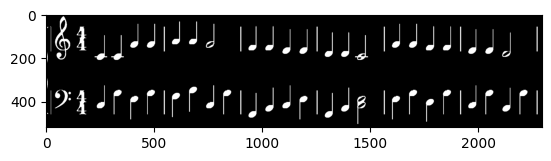

In [60]:
plt.imshow(cleaned_image, cmap='gray')
cv2.imwrite("cleaned_image.png",cleaned_image)

1187408.5
1276.5
121.0
1276.5
2318.5
304.0
304.0
1276.5
1276.5
1330.0
1330.0
1318.0
121.0
664.0
664.0
664.0
664.0
664.0
664.0
2832.0
164.0
164.0
331.0
1301.5
1301.5
1212.0
1301.5
1301.5
1212.0
1301.5
1769.5
1230.0
1313.0
1325.5
1336.0
1201.0
1201.0
1278.0
1201.0
1556.0
80.0
99.0
1472.5
1387.0
1250.5
309.0
1276.5
1276.5
1242.5
1242.5
1242.5
1242.5
688.0
688.0
688.0
688.0
688.0
688.0
2808.0
166.5
164.0
343.0
7.0
1160.5
1256.0
1256.0
1247.5
1309.5
1229.5
1373.5
319.0
1321.0
1229.5
1216.5
1216.5
6832.5
378.0
1206.5
539.0


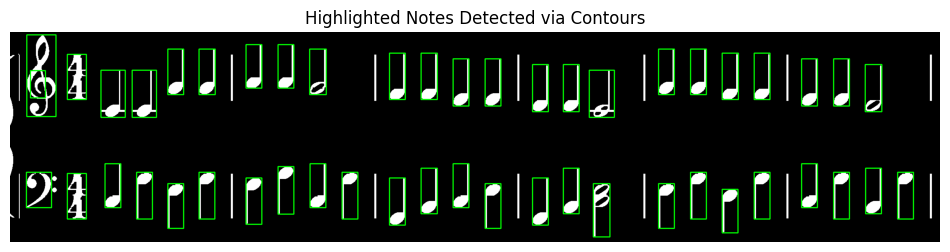

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned image
cleaned_image_path = "cleaned_image.png"  # Replace with your actual path
cleaned_image = cv2.imread(cleaned_image_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Preprocess to find contours
_, bw = cv2.threshold(cleaned_image, 150, 255, cv2.THRESH_BINARY_INV)  # Binarize
contours, _ = cv2.findContours(bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Step 2: Draw rectangles around detected contours
annotated_image = cv2.cvtColor(cleaned_image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for visualization
for cnt in contours:
    area = cv2.contourArea(cnt)
    print(area)
    if area > 1000 and area <10000:  # Filter by area
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(annotated_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw green rectangle

# Step 3: Show the result
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("Highlighted Notes Detected via Contours")
plt.axis("off")
plt.show()


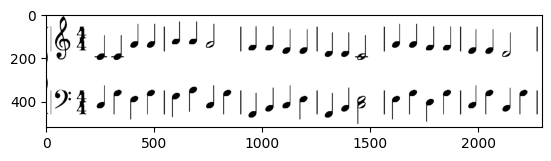

In [115]:
# Load the cleaned image
cleaned_image_path = "cleaned_image.png"  # Replace with your actual path
cleaned_image = cv2.imread(cleaned_image_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Preprocess to find contours
_, bw = cv2.threshold(cleaned_image, 150, 255, cv2.THRESH_BINARY_INV)  # Binarize
plt.imshow(bw,cmap='gray')

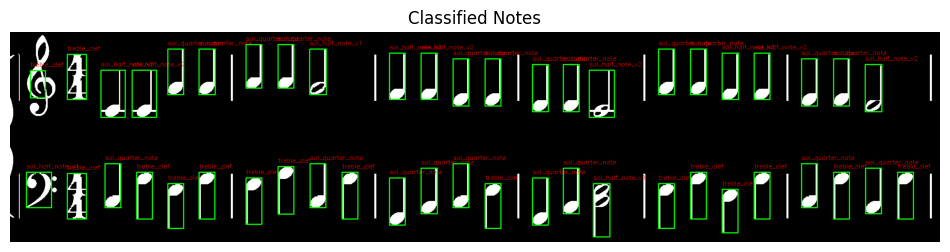

True

In [136]:
def classify_note_with_templates(note_image, templates_folder, threshold):
    """
    Classify a single note using template matching.
    Args:
        note_image (numpy.ndarray): Cropped note image.
        templates_folder (str): Path to folder containing templates.
        threshold (float): Confidence threshold for template matching.
    Returns:
        str: Detected note type (or 'Unknown').
    """
    best_match = None
    best_score = threshold
    count = 0
    for template_name in os.listdir(templates_folder):
        template_path = os.path.join(templates_folder, template_name)
        template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
        ret,template = cv2.threshold(template,50,255,cv2.THRESH_BINARY_INV)
        # Resize template to match the note region if needed
        template = cv2.resize(template, (note_image.shape[1], note_image.shape[0]))
        cv2.imwrite(f"{count}.png",template)
        count+=1
        # Perform template matching
        result = cv2.matchTemplate(note_image, template, cv2.TM_SQDIFF)
        _, max_val, _, _ = cv2.minMaxLoc(result)

        if max_val > best_score:
            best_score = max_val
            best_match = os.path.splitext(template_name)[0]  # Note type from filename

    return best_match if best_match else "Unknown"

# Paths
cleaned_image_path = "cleaned_image.png"  # Path to the cleaned image
templates_folder = "templates/"  # Path to the templates folder

# Load cleaned image
cleaned_image = cv2.imread(cleaned_image_path, cv2.IMREAD_GRAYSCALE)

# Binarize and find contours
_, binary = cv2.threshold(cleaned_image, 150, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Annotated image for visualization
annotated_image = cv2.cvtColor(cleaned_image, cv2.COLOR_GRAY2BGR)

# Classify each note
classified_notes = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if 1000 < area < 5000:  # Filter valid note sizes
        x, y, w, h = cv2.boundingRect(cnt)
        cropped_note = binary[y:y+h, x:x+w]  # Crop note from binary image
        
        # Classify the note using templates
        note_type = classify_note_with_templates(cropped_note, templates_folder, threshold=0.2)
        
        # Annotate the original image
        cv2.rectangle(annotated_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw rectangle
        cv2.putText(annotated_image, note_type, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        
        # Store the result
        classified_notes.append((x, y, w, h, note_type))

# Display the annotated image
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("Classified Notes")
plt.axis("off")
plt.show()

# Save the annotated image
cv2.imwrite("classified_notes.png", annotated_image)


In [4]:
text = "abc"
print(text[0:3])

abc
